<a href="https://colab.research.google.com/github/shahad-jeza/kaust_training/blob/main/summer_basic_code/GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Question

In [ ]:
# Graph Neural Networks (GNNs) Practice Notebook

import numpy as np
import torch
import torch_geometric
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt

# Task 1: Data Preparation (10 points)
# Load the Cora dataset and print basic information about it

# Your code here

# Task 2: Implement a Simple GCN Layer (15 points)
# Create a custom GCNConv layer without using torch_geometric's built-in GCNConv

class CustomGCNConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CustomGCNConv, self).__init__()
        # Your code here

    def forward(self, x, edge_index):
        # Your code here
        return x

# Task 3: Build a GCN Model (20 points)
# Create a GCN model using your custom GCNConv layer or torch_geometric's GCNConv

class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        # Your code here

    def forward(self, data):
        # Your code here
        return x

# Task 4: Train the GCN (25 points)
# Implement the training loop for your GCN model

# Your code here

# Task 5: Evaluate the Model (15 points)
# Implement the evaluation function and calculate accuracy on the test set

# Your code here

# Task 6: Visualize Node Embeddings (15 points)
# Use t-SNE to visualize the learned node embeddings

# Your code here

# Bonus Task: Implement Graph Attention Network (GAT) (20 bonus points)
# Modify your GCN to implement a GAT layer and model

# Your code here



---



# Solution

In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.8 MB/s eta 0:00:00


In [10]:
!pip install --upgrade torch-geometric torch-sparse torch-scatter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=1092570 sha256=6dc223592f54e9694dbaa96ba0001d976a4e619d92fc74b3489674da30e8cf33
  Stored in directory: /root/.cache/pip/wheels/c9/dd/0f/a6a16f9f3b0236733d257b4b4ea91b548b984a341ed3b8f38c
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=507270 sha256=1d8d2f2361d73027f12edf8ae5b61f91324958a3053f54e7f7d7b85d69a15391
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
Successfully built torch-sparse torch-scatter


In [11]:
import numpy as np
import torch
import torch_geometric
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
from torch_scatter import scatter_add

about the dataset: Nodes represent documents and edges represent citation links

In [12]:
# Load the Cora dataset and print basic information about it
dataset = Planetoid(root='data/Planetoid', name='Cora')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Number of node features: {dataset.num_node_features}')
print(f'Number of edge features: {dataset.num_edge_features}')
#

Number of graphs: 1
Number of features: 1433
Number of classes: 7
Number of node features: 1433
Number of edge features: 0


In [13]:
data = dataset[0]
print(data)
print("\nSample of node features:")
print(data.x[:5])
print("\nSample of node labels:")
print(data.y[:5])

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

Sample of node features:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Sample of node labels:
tensor([3, 4, 4, 0, 3])


In [17]:
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class CustomGCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomGCNConv, self).__init__(aggr='add')  # "Add" aggregation
        self.linear = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # Add self-loops to the adjacency matrix
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Compute normalization
        row, col = edge_index
        deg = degree(row, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Linear transformation
        x = self.linear(x)

        # Start propagating messages
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        # Normalize node features
        return norm.view(-1, 1) * x_j

In [18]:
# Create a GCN model using your custom GCNConv layer or torch_geometric's GCNConv

class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = CustomGCNConv(num_features, 16)
        self.conv2 = CustomGCNConv(16, num_classes)
        self.relu = torch.nn.ReLU()


    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return torch.log_softmax(x, dim=1)

In [19]:
# Implement the training loop for your GCN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(dataset.num_features, dataset.num_classes).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = torch.nn.functional.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')


Epoch 0, Loss: 1.9479
Epoch 10, Loss: 0.9005
Epoch 20, Loss: 0.1994
Epoch 30, Loss: 0.0479
Epoch 40, Loss: 0.0221
Epoch 50, Loss: 0.0185
Epoch 60, Loss: 0.0204
Epoch 70, Loss: 0.0225
Epoch 80, Loss: 0.0227
Epoch 90, Loss: 0.0215
Epoch 100, Loss: 0.0198
Epoch 110, Loss: 0.0184
Epoch 120, Loss: 0.0172
Epoch 130, Loss: 0.0163
Epoch 140, Loss: 0.0155
Epoch 150, Loss: 0.0147
Epoch 160, Loss: 0.0141
Epoch 170, Loss: 0.0135
Epoch 180, Loss: 0.0130
Epoch 190, Loss: 0.0125


In [20]:
# Implement the evaluation function and calculate accuracy on the test set
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8100


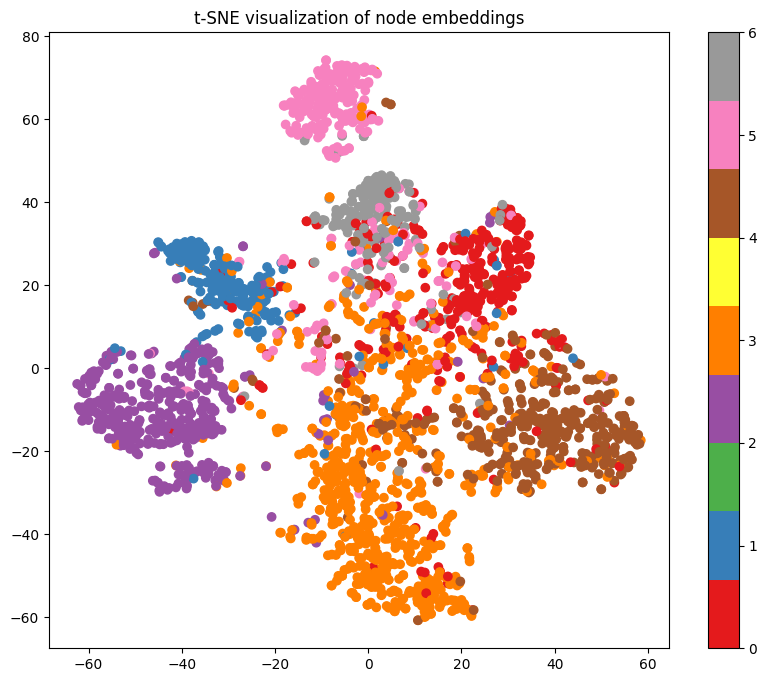

In [22]:
# Use t-SNE to visualize the learned node embeddings
from sklearn.manifold import TSNE

model.eval()
with torch.no_grad():
    embeddings = model.conv1(data.x, data.edge_index).cpu().numpy()

tsne = TSNE(n_components=2, random_state=42)
node_embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], c=data.y.cpu().numpy(), cmap='Set1')
plt.colorbar(scatter)
plt.title('t-SNE visualization of node embeddings')
plt.show()



---



In [23]:
#Implement Graph Attention Network (GAT)

from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, 8, heads=8, dropout=0.6)
        self.conv2 = GATConv(8 * 8, num_classes, heads=1, concat=False, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.nn.functional.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = torch.nn.functional.elu(x)
        x = torch.nn.functional.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return torch.log_softmax(x, dim=1)

# Train and evaluate GAT model
gat_model = GAT(dataset.num_features, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.005, weight_decay=5e-4)

gat_model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = gat_model(data)
    loss = torch.nn.functional.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

gat_model.eval()
pred = gat_model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'GAT Accuracy: {acc:.4f}')

Epoch 0, Loss: 1.9375
Epoch 10, Loss: 1.1166
Epoch 20, Loss: 0.9432
Epoch 30, Loss: 0.6280
Epoch 40, Loss: 0.5564
Epoch 50, Loss: 0.5523
Epoch 60, Loss: 0.4834
Epoch 70, Loss: 0.4633
Epoch 80, Loss: 0.3648
Epoch 90, Loss: 0.4955
Epoch 100, Loss: 0.4492
Epoch 110, Loss: 0.5208
Epoch 120, Loss: 0.4302
Epoch 130, Loss: 0.4331
Epoch 140, Loss: 0.3905
Epoch 150, Loss: 0.3865
Epoch 160, Loss: 0.4070
Epoch 170, Loss: 0.3917
Epoch 180, Loss: 0.3421
Epoch 190, Loss: 0.3215
GAT Accuracy: 0.8010
